# Steps to create a ConBacktester Class
1. Initialise the properties symbol, start, end, tc, results
2. Add the method get_data() to retrieve and prepare data from the csv file. Call get_data() in the dunder init method
3. Add the method test_strategy() with parameter window = 
4. Add the method plot_results()
5. Add the method optimize_parameter(). Only one parameter, no combinations required
6. Add appropriate string representation and docstrings
7. Save the file with .py extension to be able to imoport ConBacktester from it later

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
# Instantiating the ConBacktester class

class ConBacktester():
    ''' Class for Vectorised Backtesting of simple Contrarian trading strategies.
    '''
    
    def __init__(self, symbol, start, end, tc):
        '''
        Parameters
        ---------
        symbol: str
            ticker symbol (instrument) to be backtested
        start: str
            start date for data import
        end: str
            end date for data import
        tc: float
            proportional transaction/trading costs per trade
        '''
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        
        
    def __repr__(self):
        return 'ConBacktester(symbol = {}, start = {}, end = {},)'.format(self.symbol, self.start, self.end)
    
    
    def get_data(self):
        ''' Imports the data from csv file. Source can be changed.
        '''
        raw = pd.read_csv('intraday_pairs.csv', parse_dates = ['time'], index_col = 'time')
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns = {self.symbol : 'price'}, inplace = True)
        raw['returns'] = np.log(raw / raw.shift(1)) # calculating log returns
        self.data = raw
        
        
    def test_strategy(self, window = 1):
        ''' Backtests the simple contrarian trading strategy.
        
        Parameters
        ----------
        Window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.window = window
        data = self.data.copy().dropna()
        data['position'] = -np.sign(data['returns'].rolling(self.window).mean())
        data['strategy'] = data['position'].shift(1) * data['returns']
        data.dropna(inplace = True)
        
        # determining the number of trades in each bar
        data['trades'] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        data['creturns'] = data['returns'].cumsum().apply(np.exp)
        data['cstrategy'] = data['strategy'].cumsum().apply(np.exp)
        self.results = data
        
        # absolute performance of the strategy
        perf = data['cstrategy'].iloc[-1]
        
        # out-/underperformance of the strategy
        outperf = perf - data['creturns'].iloc[-1]
        
        return round(perf, 6), round(outperf, 6)
    
    
    def plot_results(self):
        ''' Plots the performance of trading strategy and compares to 'buy and hold'.
        '''
        
        if self.results is None:
            print('Run test_strategy() first.')
        else:
            title = '{} | Window = {} | TC = {}'.format(self.symbol, self.window, self.tc)
            self.results[['creturns', 'cstrategy']].plot(title = title, figsize = (12,8))
            
            
    def optimize_parameter(self, window_range):
        ''' Finds the optimal strategy (global maximum) given the window parameter range.
        
        Parameters
        ----------
        window_range: tuple
            tuples of the form (start, end, step size)
        '''
        
        windows = range(*window_range) # unpacking tuple and  creating a range object using *
        
        results = []
        for window in windows:
            results.append(self.test_strategy(window)[0]) # iterating over range object and calculating performance
            
        best_perf = np.max(results) # best performance
        opt = windows[np.argmax(results)] # optimal parameter
        
        # run/set the optimal strategy
        self.test_strategy(opt)
        
        # create a df with many results
        many_results = pd.DataFrame(data = {'window': windows, 'performance': results})
        self.results_overview = many_results
        
        return opt, best_perf

# ConBacktester class in action

In [3]:
# assuming trading costs as 0.00007
ptc = 0.00007

In [4]:
# creating an instance of ConBacktester class
tester = ConBacktester('EURUSD', '2018-01-01', '2019-12-31', ptc)

In [5]:
tester

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31,)

In [6]:
# Running a test strategy
tester.test_strategy()

(0.963517, 0.035345)

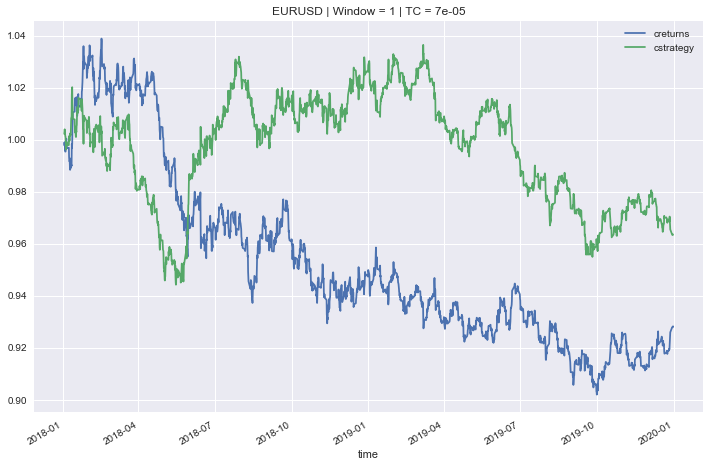

In [7]:
# Plotting results of the strategy
tester.plot_results()

In [8]:
# Checking the results dataframe
tester.results.tail()

,price,returns,position,strategy,trades,creturns,cstrategy
time,,,,,,,
2019-12-29 22:00:00+00:00,1.119920,0.002092,-1.0,-0.002092,0.0,0.927812,0.963413
2019-12-30 04:00:00+00:00,1.119940,0.000018,-1.0,-0.000018,0.0,0.927828,0.963396
2019-12-30 10:00:00+00:00,1.120095,0.000138,-1.0,-0.000138,0.0,0.927957,0.963262
2019-12-30 16:00:00+00:00,1.119920,-0.000156,1.0,0.000016,2.0,0.927812,0.963278
2019-12-30 22:00:00+00:00,1.120355,0.000388,-1.0,0.000248,2.0,0.928172,0.963517


In [9]:
# Optimising our parameters
tester.optimize_parameter((1,500,1))

(51, 1.262038)

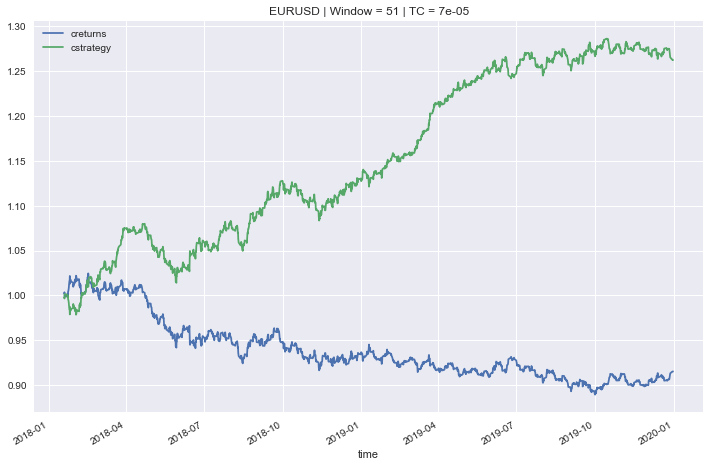

In [10]:
# Plotting results of the optimised paramter window = 51. SO we consider the last 51 6 hours bars
tester.plot_results()

In [11]:
# Results overview of different strategies
tester.results_overview

,window,performance
0,1,0.963517
1,2,0.948640
2,3,1.018994
3,4,0.824664
4,5,0.859497
...,...,...
494,495,0.983444
495,496,0.976259
496,497,0.971740
497,498,0.961736


In [12]:
# Checking top 10 biggest performing strategy window sizes
tester.results_overview.nlargest(10, 'performance')

,window,performance
50,51,1.262038
43,44,1.260746
49,50,1.238808
54,55,1.235083
53,54,1.234555
52,53,1.231764
55,56,1.228589
37,38,1.216351
51,52,1.214277
44,45,1.204657


In [13]:
# Checking worst performing strategies
tester.results_overview.nsmallest(10, 'performance')

,window,performance
3,4,0.824664
4,5,0.859497
6,7,0.884717
8,9,0.884933
10,11,0.895513
5,6,0.913512
9,10,0.916414
7,8,0.917729
255,256,0.921709
257,258,0.924776


# Running ConBacktester class on GBP/USD

In [14]:
# creating an instance of ConBackester class for GBPUSD
tester = ConBacktester('GBPUSD', '2018-01-01', '2019-12-31', 0)

In [15]:
tester.test_strategy() # testing strategy with window 1. TRADING COSTS UNACCOUNTED FOR!!

(1.079377, 0.110492)

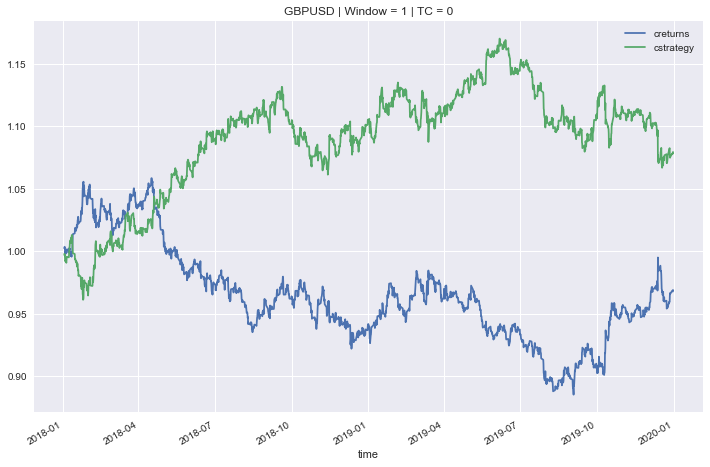

In [16]:
tester.plot_results()

In [18]:
tester.results.tail()

,price,returns,position,strategy,trades,creturns,cstrategy
time,,,,,,,
2019-12-29 22:00:00+00:00,1.311810,0.002484,-1.0,0.002484,2.0,0.968247,1.078098
2019-12-30 04:00:00+00:00,1.311880,0.000053,-1.0,-0.000053,0.0,0.968299,1.078041
2019-12-30 10:00:00+00:00,1.311465,-0.000316,1.0,0.000316,2.0,0.967992,1.078382
2019-12-30 16:00:00+00:00,1.310990,-0.000362,1.0,-0.000362,0.0,0.967642,1.077991
2019-12-30 22:00:00+00:00,1.312675,0.001284,-1.0,0.001284,2.0,0.968885,1.079377


In [19]:
tester.results.trades.value_counts() # Total number of trades undertaken

2.0    1056
0.0    1012
1.0       4
Name: trades, dtype: int64

In [20]:
tester.optimize_parameter((1,500,1)) # Optimising parameters. TRADING COSTS UNACCOUNTED FOR!!

(56, 1.21961)

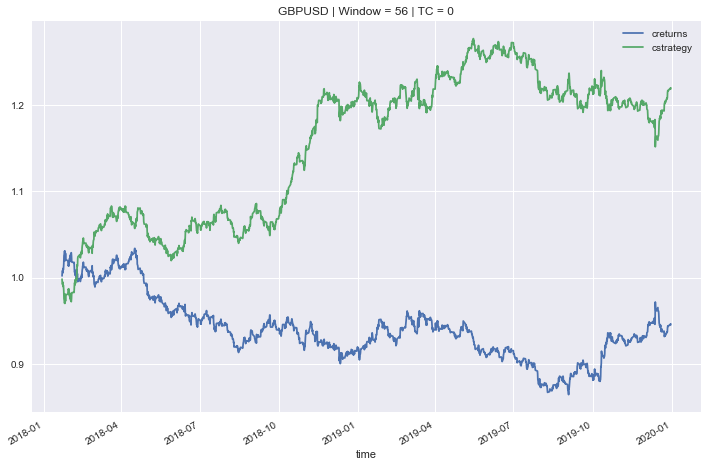

In [21]:
tester.plot_results()

In [22]:
tester.results.trades.value_counts()

0.0    1900
2.0     117
Name: trades, dtype: int64